# FP16 embeddings on OGBL-WikiKG2

<em>Copyright (c) 2023 Graphcore Ltd. All rights reserved.</em>

BESS-KGE (`besskge`) is a PyTorch library for knowledge graph embedding (KGE) models on IPUs implementing the distribution framework [BESS](https://arxiv.org/abs/2211.12281), with embedding tables stored in the IPU SRAM.

The aim of this notebook is to show how to use FP16 weights to reduce memory requirements for KGE models and speed up computations. This is especially important when dealing with knowledge graphs with a large number of entities, whose embeddings - if stored in FP32 - would require too many IPUs.

As a study case we look at the [ogbl-wikikg2](https://ogb.stanford.edu/docs/linkprop/#ogbl-wikikg2) dataset, a knowledge graph containing 2.5M entities.

If you have not done already done so, we suggest running the [KGE Training and Inference on OGBL-BioKG](1_biokg_training_inference.ipynb) notebook to get familiar with the basic functionalities of the BESS-KGE library.

## Environment setup

The best way to run this demo is on Paperspace Gradient's cloud IPUs because everything is already set up for you.

<!-- [![Run on Gradient](../../gradient-badge.svg)](https://console.paperspace.com/github/<runtime-repo>?machine=Free-IPU-POD4&container=<dockerhub-image>&file=<path-to-file-in-repo>)   -->

To run the demo using other IPU hardware, you need to have the Poplar SDK enabled {and a PopTorch/TensorFlow wheel installed}. Refer to the [Getting Started guide](https://docs.graphcore.ai/en/latest/getting-started.html#getting-started) for your system for details on how to do this. Also refer to the [Jupyter Quick Start guide](https://docs.graphcore.ai/projects/jupyter-notebook-quick-start/en/latest/index.html) for how to set up Jupyter to be able to run this notebook on a remote IPU machine.

## Dependencies

We recommend that you install `besskge` directly from the GitHub sources:

In [1]:
# Install BESS-KGE from Github releases
import sys
!{sys.executable} -m pip uninstall -y besskge
!pip install -q git+ssh://git@github.com/graphcore-research/bess-kge.git
!pip install -q matplotlib

Found existing installation: besskge 0.1
Uninstalling besskge-0.1:
  Successfully uninstalled besskge-0.1


Next, import the necessary dependencies. 

In [2]:
import pathlib
import time

import matplotlib.pyplot as plt
import numpy as np
import poptorch
import torch

from besskge.batch_sampler import RandomShardedBatchSampler, RigidShardedBatchSampler
from besskge.bess import EmbeddingMovingBessKGE, ScoreMovingBessKGE, TopKQueryBessKGE
from besskge.dataset import KGDataset
from besskge.embedding import NormalInitializer
from besskge.loss import SampledSoftmaxCrossEntropyLoss
from besskge.metric import Evaluation
from besskge.negative_sampler import (
    PlaceholderNegativeSampler,
    RandomShardedNegativeSampler,
    TripleBasedShardedNegativeSampler,
)
from besskge.scoring import TransE
from besskge.sharding import PartitionedTripleSet, Sharding

/nethome/albertoc/research/knowledge_graphs/bess-kge-poptorch/.venv_clean/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Sharding entities and triples

The OGBL-WikiKG2 dataset can be downloaded and preprocessed with the built-in method of `KGDataset`, `build_wikikg2`. Sharding of entities and triples is performed as shown in the [KGE Training and Inference on OGBL-BioKG](1_biokg_training_inference.ipynb) notebook.

In [3]:
wikikg = KGDataset.build_wikikg2(root=pathlib.Path("../datasets/wikikg2"))

print(f"Number of entities: {wikikg.n_entity:,}\n")
print(f"Number of relation types: {wikikg.n_relation_type}\n")
print(f"Number of triples: \n training: {wikikg.triples['train'].shape[0]:,} \n validation/test: {wikikg.triples['valid'].shape[0]:,}\n")
print(f"Number of negative heads/tails for validation/test triples: {wikikg.neg_heads['valid'].shape[-1]}")

Number of entities: 2,500,604

Number of relation types: 535

Number of triples: 
 training: 16,109,182 
 validation/test: 429,456

Number of negative heads/tails for validation/test triples: 500


In [4]:
# Train on 4 IPUs
n_shard = 4

seed = 1234

sharding = Sharding.create(n_entity=wikikg.n_entity, n_shard=n_shard, seed=seed)

print(f"Number of total entities: {sharding.n_entity:,}\n")

print(f"Number of shards: {sharding.n_shard}\n")

print(f"Number of entities in each shard: {sharding.max_entity_per_shard:,}\n")

print(f"Global entity IDs on {n_shard} shards:\n {sharding.shard_and_idx_to_entity}\n")

Number of total entities: 2,500,604

Number of shards: 4

Number of entities in each shard: 625,151

Global entity IDs on 4 shards:
 [[      2       5       6 ... 2500591 2500592 2500596]
 [      8       9      17 ... 2500590 2500600 2500602]
 [      1       3       7 ... 2500597 2500601 2500603]
 [      0       4      10 ... 2500594 2500598 2500599]]



In [5]:
train_triples = PartitionedTripleSet.create_from_dataset(dataset=wikikg, part="train", sharding=sharding, partition_mode="ht_shardpair")

print(f"Number of triples per (h,t) shard-pair:\n {train_triples.triple_counts}")

Number of triples per (h,t) shardpair:
 [[1174534  912862 1155842  785030]
 [1172594  912466 1155230  785851]
 [1171112  912701 1156933  786359]
 [1172898  910677 1157561  786532]]


## Interleaved training and validation (vs all)

We use the `RandomShardedBatchSampler` batch sampler class, which creates a batch by randomly sampling (with replacement) a fixed number (=`batch_sampler.positive_per_partition`) of triples from each of the 16 shard-pairs.

Negative entities, used to construct negative samples, are also sampled randomly using the `RandomShardedNegativeSampler` class. Here we construct negative samples by always corrupting the tail of positive triples, as specified by the choice `corruption_scheme="t"`.

In [6]:
device_iterations = 100
accum_factor = 1
shard_bs = 512

neg_sampler = RandomShardedNegativeSampler(n_negative=32, sharding=sharding, seed=seed, corruption_scheme="t",
                                           local_sampling=False, flat_negative_format=True)

batch_sampler = RandomShardedBatchSampler(partitioned_triple_set=train_triples, negative_sampler=neg_sampler,
                              shard_bs=shard_bs, batches_per_step=device_iterations*accum_factor, seed=seed)


print(f"# triples per shard-pair per step: {batch_sampler.positive_per_partition} \n")

# Example batch
idx_sampler = iter(batch_sampler.get_dataloader_sampler(shuffle=True))
for k,v in batch_sampler[next(idx_sampler)].items():
    print(f"{k:<12} {str(v.shape):<30} {v.dtype};")

# triples per shardpair per step: 128 

head         torch.Size([100, 4, 4, 128])   torch.int32;
relation     torch.Size([100, 4, 4, 128])   torch.int32;
tail         torch.Size([100, 4, 4, 128])   torch.int32;
negative     torch.Size([100, 4, 4, 1, 32]) torch.int32;


Notice from the `negative` shape that we are **decoupling** the number of negative samples from the batch size, by using the negative sampler option `flat_negative_format=True`. Instead of sampling negative entities on a triple basis, we sample them on a shard-pair basis. In this case, each pair of devices will exchange 32 negative entities in both directions (while, if using `flat_negative_format=False`, this number would need to be a multiple of the shard batch size - see for instance the shape of `negative` in the [KGE Training and Inference on OGBL-BioKG](1_biokg_training_inference.ipynb) notebook). This of course requires the use of negative sample sharing.

Thanks to this decoupling we can increase the shard batch size without increasing the number of negative samples to score in each batch. This is important as we don't intend to use gradient accumulation (as specified by `accum_factor = 1`), thus saving on memory which would have been used by the weight accumulation tensors.

In [7]:
options = poptorch.Options()
options.replication_factor = sharding.n_shard
options.deviceIterations(device_iterations)
options._popart.setPatterns(dict(RemoveAllReducePattern=True))

# Enable stochastic rounding on IPU for more stable half-precision training
options.Precision.enableStochasticRounding(True)

train_dl = batch_sampler.get_dataloader(options=options, shuffle=True, num_workers=3, persistent_workers=True)

We will train a simple **TransE** KGE model with an embedding size of 100, in order to fit the embedding tables in the SRAM of 4 IPUs, and use **sampled softmax cross entropy loss**.

For this dataset we find it to be beneficial to construct negative samples by corrupting the tail of a positive triple using the randomly sampled negative entities in `negative` and also the **tails of the other positive triples** in the same micro-batch. This can be done simply by setting the flag `augment_negative=True` when instantiating the `EmbeddingMovingBessKGE` distribution scheme. This strategy also has the advantage of increasing the number of negative samples used in the contrastive loss without increasing the costs of gathering and communicating negative entities across IPUs.

In [8]:
loss_fn = SampledSoftmaxCrossEntropyLoss(n_entity=wikikg.n_entity)
emb_initializer = NormalInitializer()
transe_score_fn = TransE(negative_sample_sharing=True, scoring_norm=1, sharding=sharding,
                  n_relation_type=wikikg.n_relation_type, embedding_size=100,
                  entity_initializer=emb_initializer, relation_initializer=emb_initializer)

model = EmbeddingMovingBessKGE(negative_sampler=neg_sampler, score_fn=transe_score_fn,
                               loss_fn=loss_fn, augment_negative=True)

print(f"# model parameters: {model.n_embedding_parameters:,}")

# model parameters: 250,113,900


As in standard PyTorch, we can use `model.half()` to **cast the embedding tables to FP16**, before wrapping the model in `poptorch.trainingModel`.

We train with SGD momentum instead of Adam, for reduced optimizer state memory usage.

In [9]:
# FP16 weights
model.half()

opt = poptorch.optim.SGD(
        model.parameters(),
        lr=0.001,
        momentum=0.95,
        velocity_accum_type=torch.float16,
    )

poptorch_model = poptorch.trainingModel(model, options=options, optimizer=opt)

# The variable entity_embedding needs to hold different values on each replica,
# corresponding to the shards of the entity embedding table
poptorch_model.entity_embedding.replicaGrouping(
            poptorch.CommGroupType.NoGrouping,
            0,
            poptorch.VariableRetrievalMode.OnePerGroup,
        )

# Compile model
batch = next(iter(train_dl))
res = poptorch_model(**{k: v.flatten(end_dim=1) for k, v in batch.items()})

poptorch_model.detachFromDevice()

[11:29:38.880] [poptorch:cpp] [warning] [DISPATCHER] Tensor (ptr 0x7ee49f0) type coerced from Long to Int
Graph compilation: 100%|██████████| 100/100 [02:02<00:00]


That's all we need to do to use FP16 weights! The triple scoring in TransE via L1 distance is also going to be performed in FP16, while - for stability reasons - the loss is always computed in FP32.

To track the performance evolution during training, we will validate at a regular cadence on a set of 4000 triples sampled randomly from the validation set. We provide **no tail candidates** (hence, scoring each (h,r,?) query against all 2.5 million entities in the knowledge graph). As this would be too slow to do on a CPU, we will perform the task on the IPU using the BESS `TopKQueryBessKGE` (see the [Knowledge Graph Completion on YAGO3-10](2_yago_topk_prediction.ipynb) notebook for more details on this class and how to use it).

To partition a custom set of triples (that is, not one of the "official" triple parts specified when creating `KGDataset`) on the fly, use the `PartitionedTripleSet.create_from_queries` function as follows.

In [10]:
n_sample_queries = 4000

val_device_iterations = 2
val_shard_bs = 512  

# Partition a random subset of n_sample_queries triples taken from wikikg.triples["valid"]
subset_val_triples = wikikg.triples["valid"][np.random.RandomState(seed=seed).choice(wikikg.triples["valid"].shape[0], n_sample_queries)]
sample_val_triples = PartitionedTripleSet.create_from_queries(wikikg, sharding, queries=subset_val_triples[:,:2],
                                                               query_mode="hr", ground_truth=subset_val_triples[:,2])                                                           

candidate_sampler = PlaceholderNegativeSampler(corruption_scheme="t", seed=seed)
bs_sample = RigidShardedBatchSampler(partitioned_triple_set=sample_val_triples, negative_sampler=candidate_sampler, shard_bs=val_shard_bs,
                                    batches_per_step=val_device_iterations, seed=seed, duplicate_batch=False, return_triple_idx=False)

print("Number of triples per h_shard:")
print(sample_val_triples.triple_counts)

Number of triples per h_shard:
[ 990 1029 1025  956]


In [11]:
val_options = poptorch.Options()
val_options.replication_factor = sharding.n_shard
val_options.deviceIterations(bs_sample.batches_per_step)
val_options.outputMode(poptorch.OutputMode.All)

sample_valid_dl = bs_sample.get_dataloader(options=val_options, shuffle=False, num_workers=2, persistent_workers=True)

# Example batch
val_batch = next(iter(sample_valid_dl))
for k,v in val_batch.items():
    print(f"{k:<12} {str(v.shape):<30}")

head         torch.Size([2, 4, 512])       
relation     torch.Size([2, 4, 512])       
tail         torch.Size([2, 4, 512])       
triple_mask  torch.Size([2, 4, 512])       


In [12]:
# Inference model

evaluation = Evaluation(["mrr"], worst_rank_infty=True, reduction="sum")

inf_model = TopKQueryBessKGE(k=10, candidate_sampler=candidate_sampler, score_fn=transe_score_fn, evaluation=evaluation, window_size=500)

poptorch_inf_model = poptorch.inferenceModel(inf_model, options=val_options)

poptorch_inf_model.entity_embedding.replicaGrouping(
            poptorch.CommGroupType.NoGrouping,
            0,
            poptorch.VariableRetrievalMode.OnePerGroup,
        )

# Compile inference model
val_res = poptorch_inf_model(**{k: v.flatten(end_dim=1) for k, v in val_batch.items()})

poptorch_inf_model.detachFromDevice()

[11:31:59.433] [poptorch:cpp] [warning] [DISPATCHER] Type coerced from Long to Int for tensor id 185
[11:31:59.450] [poptorch:cpp] [warning] [DISPATCHER] Type coerced from Long to Int for tensor id 242
[11:31:59.453] [poptorch:cpp] [warning] [DISPATCHER] Type coerced from Long to Int for tensor id 265
Graph compilation: 100%|██████████| 100/100 [02:10<00:00]


Let us train the model for 70 epochs, performing validation on the selected random set of triples every 10 epochs. This should take less than 10 minutes.

Be aware that the interleaved execution scheme introduces some overhead for detaching and attaching the executables of the two different models to the available IPUs. This overhead is **not** included in the time measurements that we print out, as it can be significantly cut down by using two separate IPU-POD4 systems, one for training and one for validation. If you are running a session with at least 8 IPUs:

* remove the `model.detachFromDevice()`, `model.attachToDevice()` parts of the code in the cells above
* remove the `model.detachFromDevice()`, `model.attachToDevice()` parts of the code in the next cell
* uncomment the 2 lines of code (`poptorch_model.copyWeightsToHost()` and `poptorch_inf_model.copyWeightsToDevice()`) in the next cell

Epoch 1 loss: 11.531570 --- positive triples processed: 1.88e+07
Epoch duration (sec): 4.63044 (average step time: 0.04902)
Epoch 1 sample MRR: 0.0487 (validation time: 0.90021)
Epoch 2 loss: 10.928529 --- positive triples processed: 3.77e+07
Epoch duration (sec): 4.46293 (average step time: 0.04845)
Epoch 3 loss: 10.393398 --- positive triples processed: 5.65e+07
Epoch duration (sec): 4.46044 (average step time: 0.04835)
Epoch 4 loss: 9.872423 --- positive triples processed: 7.54e+07
Epoch duration (sec): 4.45202 (average step time: 0.04833)
Epoch 5 loss: 9.365119 --- positive triples processed: 9.42e+07
Epoch duration (sec): 4.45555 (average step time: 0.04837)
Epoch 6 loss: 8.897866 --- positive triples processed: 1.13e+08
Epoch duration (sec): 4.45599 (average step time: 0.04838)
Epoch 7 loss: 8.481203 --- positive triples processed: 1.32e+08
Epoch duration (sec): 4.45967 (average step time: 0.04838)
Epoch 8 loss: 8.123039 --- positive triples processed: 1.51e+08
Epoch duration (se

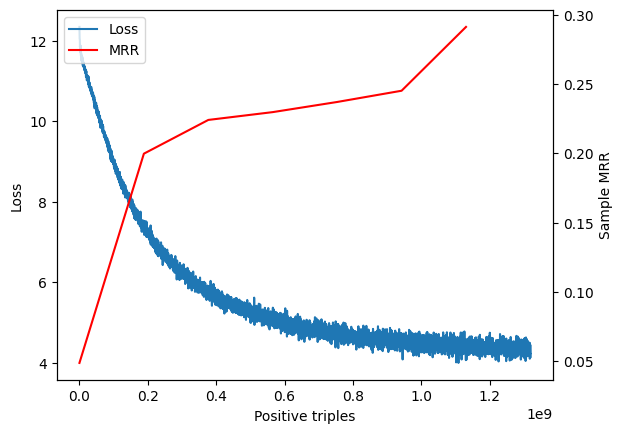

In [13]:
n_epochs = 70
val_ep_interval = 10

cumulative_triples = 0
training_loss = []
val_mrr = []
poptorch_model.attachToDevice()
for ep in range(n_epochs):
    ep_start_time = time.time()
    ep_log = []
    for batch in train_dl:
        step_start_time = time.time()
        cumulative_triples += batch["head"].numel()
        res = poptorch_model(**{k: v.flatten(end_dim=1) for k, v in batch.items()})
        ep_log.append(dict(loss= float(torch.sum(res["loss"])) / batch["head"][0].numel(), step_time=(time.time()-step_start_time)))
    ep_loss = [v['loss'] for v in ep_log]
    training_loss.extend([v['loss'] for v in ep_log])
    print(f"Epoch {ep+1} loss: {np.mean(ep_loss):.6f} --- positive triples processed: {cumulative_triples:.2e}")
    print(f"Epoch duration (sec): {(time.time() - ep_start_time):.5f} (average step time: {np.mean([v['step_time'] for v in ep_log]):.5f})")
    if ep % val_ep_interval == 0:
        poptorch_model.detachFromDevice()
        poptorch_inf_model.attachToDevice()
        # If running training and inference on separate devices, uncomment the following 2 lines:
        # poptorch_model.copyWeightsToHost()
        # poptorch_inf_model.copyWeightsToDevice()
        val_start_time = time.time()
        ep_mrr = 0.0
        for batch_val in sample_valid_dl:
            ep_mrr += poptorch_inf_model(**{k: v.flatten(end_dim=1) for k, v in batch_val.items()})["metrics"].sum()
        ep_mrr /= n_sample_queries  
        val_mrr.append(ep_mrr)
        print(f"Epoch {ep+1} sample MRR: {ep_mrr:.4f} (validation time: {(time.time() - val_start_time):.5f})")
        poptorch_inf_model.detachFromDevice()
        poptorch_model.attachToDevice()

# Plot loss and sample MRR as a function of the number of positive triples processed
total_triples = np.cumsum(n_epochs * len(train_dl) * [batch["head"].numel()])
ax0, ax1 = plt.gca(), plt.twinx()
line0, = ax0.plot(total_triples, training_loss)
line1, = ax1.plot(total_triples[::val_ep_interval * len(train_dl)], val_mrr, color="r")
ax0.set_xlabel("Positive triples")
ax0.set_ylabel("Loss")
ax1.set_ylabel("Sample MRR")
plt.legend([line0, line1], ["Loss", "MRR"], loc="upper left")

poptorch_model.detachFromDevice()
del train_dl
del sample_valid_dl

Let us compute the final MRR on the whole validation set, containing 429k+ triples. Once again, even though the dataset provides 500 candidate tails for each triple, here we are actually scoring queries against **all entities** in the dataset.

In [14]:
validation_triples = PartitionedTripleSet.create_from_dataset(wikikg, "valid", sharding, partition_mode="h_shard")
bs_valid = RigidShardedBatchSampler(partitioned_triple_set=validation_triples, negative_sampler=candidate_sampler, shard_bs=val_shard_bs,
                                    batches_per_step=val_device_iterations, seed=seed)

print("Number of triples per h_shard:")
print(validation_triples.triple_counts)

valid_dl = bs_valid.get_dataloader(options=val_options, shuffle=False, num_workers=3)

Number of triples per h_shard:
[107164 107068 108307 106917]


In [15]:
poptorch_inf_model.attachToDevice()

val_mrr = 0.0
start_time = time.time()
n_val_queries = 0
for batch_val in valid_dl:
    n_val_queries += batch_val["triple_mask"].sum()
    val_mrr += poptorch_inf_model(**{k: v.flatten(end_dim=1) for k, v in batch_val.items()})["metrics"].sum()

print(f"Validation MRR: {val_mrr / n_val_queries}")
print(f"Validation time (sec): {(time.time() - start_time):.5f}")

poptorch_inf_model.detachFromDevice()
del valid_dl

Validation MRR: 0.271450400352478
Validation time (sec): 47.11216


## Validation (vs candidate tails)

Now we can check the metrics when scoring validation queries only against the provided candidates.

Similarly to what we did in the [KGE Training and Inference on OGBL-BioKG](1_biokg_training_inference.ipynb) notebook, we use `TripleBasedShardedNegativeSampler` to provide the model with the triple-specific candidate tails.

In [16]:
validation_triples = PartitionedTripleSet.create_from_dataset(dataset=wikikg, part="valid", sharding=sharding, partition_mode="ht_shardpair")
ns_valid = TripleBasedShardedNegativeSampler(negative_heads=validation_triples.neg_heads, negative_tails=validation_triples.neg_tails,
                                             sharding=sharding, corruption_scheme="t", seed=seed)
# We do not need to duplicate_batch as we only want to score negative tails
bs_valid = RigidShardedBatchSampler(partitioned_triple_set=validation_triples, negative_sampler=ns_valid, shard_bs=256, batches_per_step=10,
                                    seed=seed, duplicate_batch=False)

# Example batch
idx_sampler = iter(bs_valid.get_dataloader_sampler(shuffle=False))
for k,v in bs_valid[next(idx_sampler)].items():
    print(f"{k:<15} {str(v.shape):<35} {v.dtype};")

head            torch.Size([10, 4, 4, 64])          torch.int32;
relation        torch.Size([10, 4, 4, 64])          torch.int32;
tail            torch.Size([10, 4, 4, 64])          torch.int32;
triple_mask     torch.Size([10, 4, 4, 64])          torch.bool;
negative        torch.Size([10, 4, 4, 256, 172])    torch.int32;
negative_mask   torch.Size([10, 4, 256, 4, 172])    torch.bool;


As we see from the shape of `negative` and `negative_mask`, the 500 negative tails for each validation triple are retrieved in blocks of 172 entities from each of the 4 IPUs (with padding added where needed).

We use the `ScoreMovingBessKGE` version of BESS, as recommended for performing inference against triple-specific sets of candidates.

In [17]:
val_options = poptorch.Options()
val_options.replication_factor = sharding.n_shard
val_options.deviceIterations(bs_valid.batches_per_step)
val_options.outputMode(poptorch.OutputMode.All)

valid_dl = bs_valid.get_dataloader(options=val_options, shuffle=False, num_workers=3, persistent_workers=True)

# Each triple is now to be scored against a specific set of negatives, so we turn off negative sample sharing
transe_score_fn.negative_sample_sharing = False

evaluation = Evaluation(["mrr", "hits@1", "hits@5", "hits@10"], reduction="sum")
model_inf = ScoreMovingBessKGE(negative_sampler=ns_valid, score_fn=transe_score_fn, evaluation=evaluation)

poptorch_model_inf = poptorch.inferenceModel(model_inf, options=val_options)

poptorch_model_inf.entity_embedding.replicaGrouping(
            poptorch.CommGroupType.NoGrouping,
            0,
            poptorch.VariableRetrievalMode.OnePerGroup,
        )

# Compile model
batch = next(iter(valid_dl))
res = poptorch_model_inf(**{k: v.flatten(end_dim=1) for k, v in batch.items()})

[11:44:00.219] [poptorch:cpp] [warning] [DISPATCHER] Type coerced from Long to Int for tensor id 369
[11:44:00.221] [poptorch:cpp] [warning] [DISPATCHER] Type coerced from Long to Int for tensor id 375
Graph compilation: 100%|██████████| 100/100 [01:10<00:00]


In [18]:
val_log = []
start_time = time.time()
n_val_queries = 0
for batch_val in valid_dl:
    res = poptorch_model_inf(**{k: v.flatten(end_dim=1) for k, v in batch_val.items()})
    n_val_queries += batch_val["triple_mask"].sum()
    # By transposing res["metrics"] we separate the outputs for the different metrics
    val_log.append({k: v.sum() for k, v in zip(
                        evaluation.metrics.keys(),
                        res["metrics"].T,
                    )})

for metric in val_log[0].keys():
    reduced_metric = sum([l[metric] for l in val_log]) / n_val_queries
    print("%s : %f" % (metric, reduced_metric))
print(f"Validation time (sec): {(time.time() - start_time):.5f}")

poptorch_model_inf.detachFromDevice()
del valid_dl

hits@1 : 0.864221
hits@5 : 0.938641
hits@10 : 0.952705
mrr : 0.898410
Validation time (sec): 0.93663


Notice that, in this dataset, predicting tails is easier than predicting heads. 

Want to see how the model we trained performs on the complete task (scoring queries against candidate heads + candidate tails), to compare with the TransE (100dim) result on the [OGB leaderboard](https://ogb.stanford.edu/docs/leader_linkprop/#ogbl-wikikg2)? Just set `corruption_scheme="ht"` when creating the `TripleBasedShardedNegativeSampler` object and `duplicate_batch=True` in the `RigidShardedBatchSampler` and re-run the last three code cells. If this is the aim, however, you might want to corrupt both heads and tails already during training. You can do this by changing the corruption scheme of `RandomShardedNegativeSampler` accordingly before [starting training](#Interleaved-training-and-validation-(vs-all)).